In [302]:
import pandas as pd
import numpy as np
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

from scipy.stats import linregress, entropy

from sklearn.linear_model import LassoCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
from boruta import BorutaPy

import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict

In [221]:
df = pd.read_excel('1_2_ts_project_ftiad_df.xlsx')
df = df.drop(['balance', 'Unnamed: 0'], axis=1)

In [223]:
df

,date,income,outcome,saldo,avg_temp_msk,funds_on_cbr_corr_acc_russia,funds_on_cbr_corr_acc_moscow,key_rate,deposit_rate_lower_bound,repo_loans_rate_upper_bound,...,usd_vol_tomorrow,eur_rate_today,eur_vol_today,eur_rate_tomorrow,eur_vol_tomorrow,tax_payments,declaration_date,advance_date,eco_payments_date,gdp_abs
0,2017-01-09,1.343028,1.487865,-0.144836,-6.946667,2041.3,1704.7,10.0,9.0,11.0,...,2611.805,63.0176,176.525,63.0278,263.770,1.0,0.0,0.0,0.0,21703.380837
1,2017-01-10,1.068610,1.194182,-0.125572,-6.840000,1567.9,1350.4,10.0,9.0,11.0,...,3231.872,63.5227,239.949,63.5212,239.392,0.0,0.0,0.0,0.0,21710.278831
2,2017-01-11,0.944429,0.936663,0.007767,-6.733333,1526.8,1313.3,10.0,9.0,11.0,...,3663.963,63.3733,156.503,63.3437,309.014,0.0,0.0,0.0,0.0,21716.883174
3,2017-01-12,1.672202,0.875379,0.796823,-6.626667,2472.7,2280.6,10.0,9.0,11.0,...,3669.495,63.1847,198.967,63.1705,306.948,0.0,0.0,0.0,0.0,21723.199078
4,2017-01-13,0.955924,0.975645,-0.019721,-6.520000,2440.5,2219.0,10.0,9.0,11.0,...,2512.063,63.1565,165.232,63.2411,232.421,0.0,0.0,0.0,1.0,21729.231757
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1538,2021-03-27,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23382.417486
1539,2021-03-28,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23383.356030
1540,2021-03-29,2.356883,3.370738,-1.013855,6.913333,2565.7,2401.8,4.5,3.5,5.5,...,2293.707,89.3914,118.831,89.3448,289.155,1.0,1.0,0.0,0.0,23384.053176
1541,2021-03-30,2.317382,2.567554,-0.250172,7.206667,2426.4,2296.4,4.5,3.5,5.5,...,3024.296,88.9712,272.726,89.0471,299.402,0.0,1.0,0.0,0.0,23384.503105


In [156]:
df = pd.read_excel('ts_data_new_filled_v2.xlsx')
df = df.drop('Balance', axis = 1)

### 0. Базовые функции для работы пайплайна

In [100]:
"""
Модуль для автоматизированного отбора признаков.
Реализует три категории методов:
 1) Filter: Mutual Information + mRMR
 2) Wrapper: Boruta (RandomForest)
 3) Embedded: Lasso / ElasticNet

А также последовательный pipeline: filter → wrapper → embedded.
"""

def filter_selection_mrmr(df: pd.DataFrame,
                          feature_cols: list[str],
                          target_col: str,
                          k: int = 10,
                          random_state: int = 42) -> list[str]:
    """
    Filter: mRMR отбор признаков.
    1) Вычисляем MI(f; y)
    2) Жадно добавляем по критерию: MI(f; y) - avg_s MI(f; s)
    """
    df_clean = df.dropna(subset=feature_cols + [target_col])
    X = df_clean[feature_cols]
    y = df_clean[target_col].values

    # mutual information с таргетом
    mi_target = dict(zip(
        feature_cols,
        mutual_info_regression(X.values, y, random_state=random_state)
    ))

    selected = []
    candidates = set(feature_cols)

    while len(selected) < k and candidates:
        scores = {}
        for f in tqdm(candidates):
            red = 0.0
            if selected:
                # средняя MI с уже выбранными
                mis = []
                for s in selected:
                    mi_fs = mutual_info_regression(
                        df_clean[[f]].values,
                        df_clean[s].values,
                        random_state=random_state
                    )[0]
                    mis.append(mi_fs)
                red = np.mean(mis)
            scores[f] = mi_target[f] - red
        best = max(scores, key=scores.get)
        selected.append(best)
        candidates.remove(best)
    return selected


def boruta_selection(df: pd.DataFrame,
                      feature_cols: list[str],
                      target_col: str,
                      n_estimators: int = 100,
                      random_state: int = 42) -> list[str]:
    """
    Wrapper: BorutaPy на основе RandomForestRegressor.
    Возвращает список фич, поддержанных Boruta.
    """
    df_clean = df.dropna(subset=feature_cols + [target_col])
    X = df_clean[feature_cols].values
    y = df_clean[target_col].values

    rf = RandomForestRegressor(
        n_estimators=n_estimators,
        random_state=random_state,
        n_jobs=-1
    )
    boruta = BorutaPy(estimator=rf,
                      n_estimators='auto',
                      random_state=random_state)
    boruta.fit(X, y)

    selected = [f for f, keep in zip(feature_cols, boruta.support_) if keep]
    return selected


def embedded_selection(df: pd.DataFrame,
                       feature_cols: list[str],
                       target_col: str,
                       method: str = 'lasso',
                       cv: int = 5,
                       random_state: int = 42) -> list[str]:
    """
    Embedded: LassoCV или ElasticNetCV.
    Возвращает фичи с ненулевыми коэффициентами.
    """
    df_clean = df.dropna(subset=feature_cols + [target_col])
    X = df_clean[feature_cols].values
    y = df_clean[target_col].values

    if method == 'elasticnet':
        model = ElasticNetCV(cv=cv, random_state=random_state).fit(X, y)
    else:
        model = LassoCV(cv=cv, random_state=random_state).fit(X, y)

    coefs = model.coef_
    selected = [f for f, c in zip(feature_cols, coefs) if abs(c) > 1e-6]
    return selected


def sequential_feature_selection(
    df: pd.DataFrame,
    feature_cols: list[str],
    target_col: str,
    k_filter: int = 30,
    boruta_n_estimators: int = 100,
    embedded_method: str = 'lasso',
    cv: int = 5,
    random_state: int = 42
) -> dict:
    """
    Запускает отбор признаков последовательно:
      1) Filter (mRMR) → top k_filter
      2) Wrapper (Boruta) → subset
      3) Embedded (Lasso/ElasticNet) → финальный набор

    Возвращает словарь:
      {
        'filter': [...],
        'wrapper': [...],
        'embedded': [...],
        'final': [...]  # совпадает с 'embedded'
      }
    """
    # 1. Filter
    filt = filter_selection_mrmr(
        df, feature_cols, target_col,
        k=k_filter, random_state=random_state
    )
    # 2. Wrapper на отфильтрованных
    wrap = boruta_selection(
        df, filt, target_col,
        n_estimators=boruta_n_estimators,
        random_state=random_state
    )
    # 3. Embedded на оставшихся
    emb = embedded_selection(
        df, wrap, target_col,
        method=embedded_method,
        cv=cv,
        random_state=random_state
    )
    return {
        'filter': filt,
        'wrapper': wrap,
        'embedded': emb,
        'final': emb
    }

In [231]:
def add_calendar_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["dow"] = df.index.dayofweek
    df["month"] = df.index.month
    df["is_month_end"] = df.index.is_month_end.astype(int)
    df["is_quarter_end"] = df.index.is_quarter_end.astype(int)
    return df

def add_lag_features(df: pd.DataFrame, cols: list[str], n_lags: int = 30) -> pd.DataFrame:
    """
    Для каждого столбца в cols генерирует n_lags лагов: col_lag1 ... col_lag{n_lags}.
    """
    df = df.copy()
    for col in cols:
        for lag in range(1, n_lags + 1):
            df[f"{col}_lag{lag}"] = df[col].shift(lag)
    return df


def add_rolling_features(df: pd.DataFrame,
                         cols: list[str],
                         windows: list[int] = [7, 30],
                         stats: list[str] = ['mean', 'std']) -> pd.DataFrame:
    """
    Добавляет для каждого col и каждого окна w в windows:
      - скользящее среднее:    col_roll_mean_{w}
      - скользящее std отклон: col_roll_std_{w}
    Все скользящие рассчитываются с задержкой 1 периода.
    """
    df = df.copy()
    for col in cols:
        for w in windows:
            roll = df[col].shift(1).rolling(window=w, min_periods=1)
            if 'mean' in stats:
                df[f"{col}_roll_mean_{w}"] = roll.mean()
            if 'std' in stats:
                df[f"{col}_roll_std_{w}"]  = roll.std()
    return df


def add_diff_features(df: pd.DataFrame, cols: list[str]) -> pd.DataFrame:
    """
    Добавляет первые разности для каждого col: col_diff1 = col - col.shift(1).
    Помогает убрать тренд.
    """
    df = df.copy()
    for col in cols:
        df[f"{col}_diff1"] = df[col].diff(1)
    return df


def generate_features(df: pd.DataFrame,
                            target_col: str = 'Saldo',
                            lag_target: int = 7,
                            lag_macro: int = 3,
                            roll_windows: list[int] = [7, 30]) -> pd.DataFrame:
    """
    Собирает итоговую матрицу признаков:
    1. Календарные признаки
    2. Лаги по target_col
    3. Лаги для макрофакторов (lag_macro)
    4. Скользящие статистики по target_col
    5. Первые разности по target_col
    6. Существующие tax_*, macro, usd/eur поля и флаги сохраняются

    Возвращает DataFrame, готовый к обучению (с удалёнными NaN).
    """
    df_feat = df.copy()

    # 1. Calendar
    df_feat = add_calendar_features(df_feat)

    # 2. Lags of target
    df_feat = add_lag_features(df_feat, cols=[target_col], n_lags=lag_target)
    
    # 4. Rolling stats of target
    df_feat = add_rolling_features(df_feat, cols=[target_col], windows=roll_windows)

    # 5. First differences of target
    df_feat = add_diff_features(df_feat, cols=[target_col])

    # 6. Удаляем NaN-строки
    df_feat.dropna(inplace=True)
    return df_feat

In [77]:
class DriftDetector:
    def __init__(self, window_size=20, ewma_alpha=0.3, cusum_threshold=5):
        self.window_size = window_size
        self.ewma_alpha = ewma_alpha
        self.cusum_threshold = cusum_threshold
        self.ewma_prev = None
        self.cusum_pos = 0
        self.cusum_neg = 0

    def detect(self, series: pd.Series) -> bool:
        if len(series) < self.window_size:
            return False

        rolling_mean = series.rolling(window=self.window_size).mean()
        rolling_std = series.rolling(window=self.window_size).std()

        val = series.iloc[-1]
        mean = rolling_mean.iloc[-1]
        std = rolling_std.iloc[-1]

        # EWMA
        if self.ewma_prev is None:
            self.ewma_prev = val
        ewma = self.ewma_alpha * val + (1 - self.ewma_alpha) * self.ewma_prev
        self.ewma_prev = ewma

        ewma_deviation = abs(val - ewma)

        # CUSUM
        k = 0.5 * std
        self.cusum_pos = max(0, self.cusum_pos + val - mean - k)
        self.cusum_neg = min(0, self.cusum_neg + val - mean + k)

        cusum_alert = self.cusum_pos > self.cusum_threshold or abs(self.cusum_neg) > self.cusum_threshold

        # Логика триггера разладки
        if ewma_deviation > 2 * std or cusum_alert:
            print(f"Drift detected: EWMA deviation = {ewma_deviation}, CUSUM = {self.cusum_pos}/{self.cusum_neg}")
            return True

        return False

### Базовый ARIMApipeline (НЕ для проекта. Для проекта - второй)

In [225]:
class ARIMAPipeline:
    """
    - генерация и отбор признаков по входящим данным
    - итеративное разделение на train/valid/test
    - имитация увеличивающейся обучающей выборки или скользящего окна
    - заполнение пропусков
    - автоматический ре-трейн по расписанию и при дрейфе
    - логирование MAE и флага ре-трейна
    """
    def __init__(self,
                 dataframe: pd.DataFrame,
                 date_col: str = 'date',
                 target_col: str = 'saldo',
                 train_sample_format: str = 'increasing',  # 'increasing' или 'sliding_window'
                 inplace_type: str = '-1e10',              # или 'mean'
                 test_days: int = 30,
                 min_train_days: int = 60,
                 retrain_freq: int = 30,
                 drift_threshold: float = 0.05):
        self.df = dataframe.copy()
        self.date_col = date_col
        self.target_col = target_col
        self.train_sample_format = train_sample_format
        self.inplace_type = inplace_type
        self.test_days = test_days
        self.min_train_days = min_train_days
        self.retrain_freq = retrain_freq
        self.drift_threshold = drift_threshold

        # 0. Подготовка датафрейма
        self.df[self.date_col] = pd.to_datetime(self.df[self.date_col])
        self.df.sort_values(self.date_col, inplace=True)
        self.df.set_index(self.date_col, inplace=True)
        self.df = self.df.asfreq('D').fillna(method='ffill')

        self.scaler = StandardScaler()
        
        self.selected_features = None
        self.model = None
        self.last_retrain_idx = None

        self.df_results = pd.DataFrame(columns=[
            'Date', 'train_period', 'test_period', 'MAE', 'Retrained'
        ])

    def run_loop(self) -> pd.DataFrame:
        prev_mae = None
          
        # Итерации по точкам разбиения
        for idx in tqdm(range(self.min_train_days,
                               len(self.df) - self.test_days + 1)):

            # формируем train и test
            if self.train_sample_format == 'increasing':
                df_train = self.df.iloc[:idx]
            else:
                df_train = self.df.iloc[idx - self.min_train_days:idx]
            df_test = self.df.iloc[idx: idx + self.test_days]

            # train/valid split
            train_split, valid_split = train_test_split(
                df_train, test_size=0.2, shuffle=False)
            # разделяем X/y
            x_train = train_split.drop(columns=[self.target_col])
            y_train = train_split[self.target_col]
            x_valid = valid_split.drop(columns=[self.target_col])
            y_valid = valid_split[self.target_col]
            x_test  = df_test.drop(columns=[self.target_col])
            y_test  = df_test[self.target_col]

            # заполнение пропусков
            if self.inplace_type == '-1e10':
                fill_val = -1e10
                x_train.fillna(fill_val, inplace=True)
                x_valid.fillna(fill_val, inplace=True)
                x_test.fillna(fill_val, inplace=True)
            else:
                mean_vals = x_train.mean()
                x_train.fillna(mean_vals, inplace=True)
                x_valid.fillna(mean_vals, inplace=True)
                x_test.fillna(mean_vals, inplace=True)

            train_period = f"{y_train.index.min().date()}/{y_train.index.max().date()}"
            test_period  = f"{y_test.index.min().date()}/{y_test.index.max().date()}"

            # определяем необходимость ре-трейна
            retrained = False
            if (self.model is None or
                (self.last_retrain_idx is not None and idx - self.last_retrain_idx >= self.retrain_freq)):
                retrained = True
                self._train_model(pd.concat([x_train, x_valid]),
                                   pd.concat([y_train, y_valid]))
                self.last_retrain_idx = idx

            # прогноз
            x_test_feat = x_test[self.selected_features]
            X_test_scaled = self.scaler.transform(x_test_feat)
            y_pred = self.model.predict(n_periods=len(X_test_scaled), X=X_test_scaled)

            mae = mean_absolute_error(y_test, y_pred)

            # проверка дрейфа
            if prev_mae is not None and mae - prev_mae > self.drift_threshold:
                retrained = True
                self._train_model(pd.concat([x_train, x_valid]),
                                   pd.concat([y_train, y_valid]))
                X_test_scaled = self.scaler.transform(
                    x_test[self.selected_features]
                )
                y_pred = self.model.predict(n_periods=len(X_test_scaled), X=X_test_scaled)
                mae = mean_absolute_error(y_test, y_pred)
                self.last_retrain_idx = idx

            # логирование результатов
            self.df_results.loc[len(self.df_results)] = [
                y_test.index[-1].date(),
                train_period,
                test_period,
                mae,
                retrained
            ]
            prev_mae = mae

        return self.df_results

    def _train_model(self, X: pd.DataFrame, y: pd.Series):
        # фичер-селекшн

        
        
        self.selected_features = X.columns.tolist()  # или вызвать feature selection
        # масштабирование
        X_scaled = self.scaler.fit_transform(X[self.selected_features])
        # обучение auto_arima
        self.model = auto_arima(
            y=y,
            exogenous=X_scaled,
            seasonal=True,
            m=7,
            error_action='ignore',
            suppress_warnings=True,
            stepwise=True
        )

In [182]:
arima_pipeline = ARIMAPipeline(df)

In [184]:
results = arima_pipeline.run_loop()

100%|██████████| 1454/1454 [13:29<00:00,  1.80it/s]


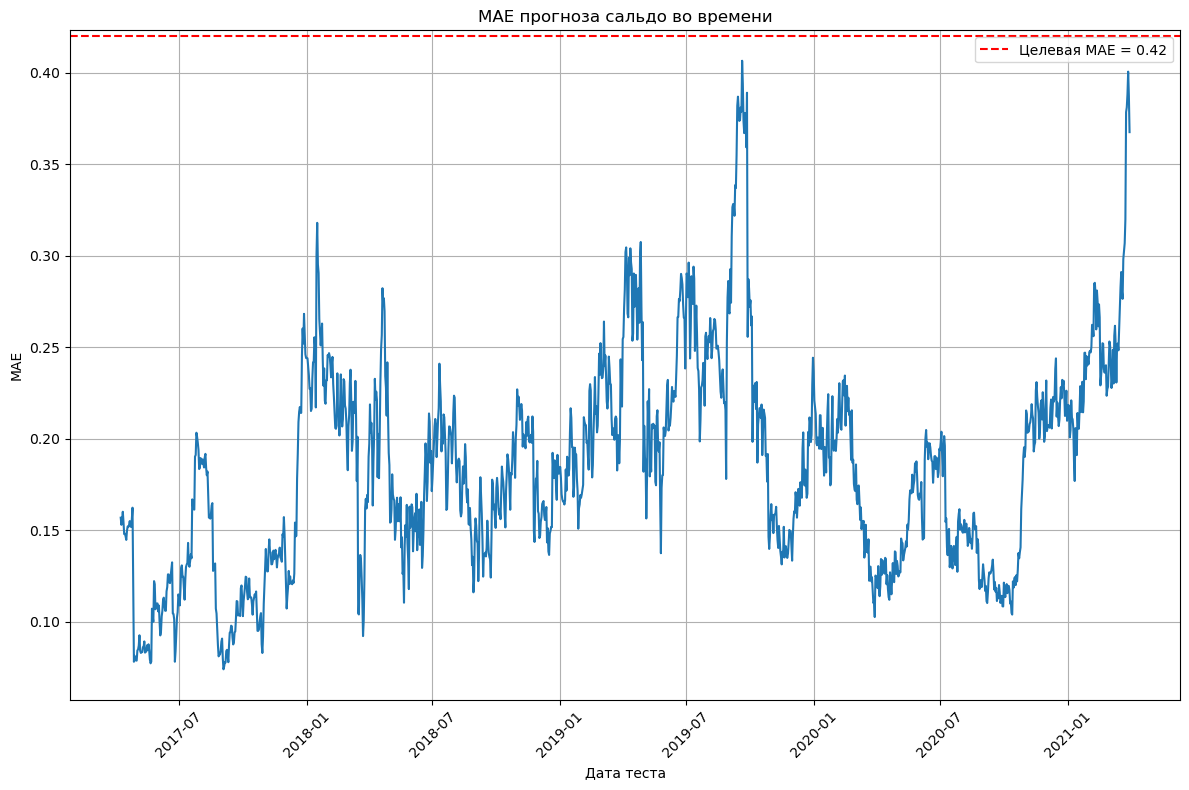

In [200]:
df_res = results.copy()

# Если Date хранится не в datetime
df_res['Date'] = pd.to_datetime(df_res['Date'])

# Построение
plt.figure(figsize=(12, 8))
plt.plot(df_res['Date'], df_res['MAE'], linestyle='-')
plt.axhline(y=0.42, color='red', linestyle='--', label='Целевая MAE = 0.42')
plt.title('MAE прогноза сальдо во времени')
plt.xlabel('Дата теста')
plt.ylabel('MAE')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

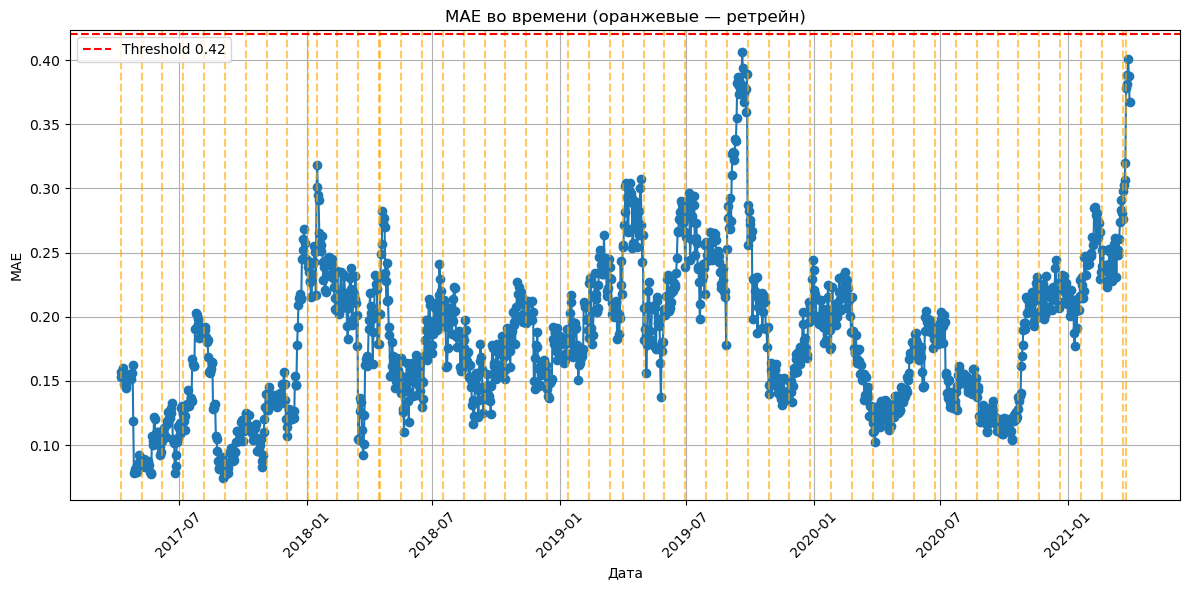

In [198]:
# Отметить ретрейн-периоды
retrain_dates = df_res.loc[df_res['Retrained'], 'Date']

plt.figure(figsize=(12, 6))
plt.plot(df_res['Date'], df_res['MAE'], marker='o', linestyle='-')
for d in retrain_dates:
    plt.axvline(d, color='orange', linestyle='--', alpha=0.6)
plt.axhline(y=0.42, color='red', linestyle='--', label='Threshold 0.42')
plt.title('MAE во времени (оранжевые — ретрейн)')
plt.xlabel('Дата')
plt.ylabel('MAE')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### 1. ДЛЯ ПРОЕКТА Наивный пайплайн

In [278]:
class NaiveForecast:
    """
    Наивные прогнозы для временных рядов. Реализует три стратегии:
    - 'last': последнее известное значение
    - 'mean': среднее значение тренировочного периода
    - 'seasonal': повтор последнего сезона (требует задания season_length)
    """
    def __init__(self,
                 dataframe: pd.DataFrame,
                 date_col: str = 'date',
                 target_col: str = 'saldo',
                 strategy: str = 'last',
                 train_sample_format: str = 'increasing',
                 test_days: int = 30,
                 min_train_days: int = 60,
                 season_length: int = 7):
        
        self.df = dataframe.copy()
        self.date_col = date_col
        self.target_col = target_col
        self.strategy = strategy
        self.train_sample_format = train_sample_format
        self.test_days = test_days
        self.min_train_days = min_train_days
        self.season_length = season_length

        # Подготовка данных
        self.df[self.date_col] = pd.to_datetime(self.df[self.date_col])
        self.df.sort_values(self.date_col, inplace=True)
        self.df.set_index(self.date_col, inplace=True)
        self.df = self.df.asfreq('D').fillna(method='ffill')

        # Результаты
        self.df_results = pd.DataFrame(columns=[
            'Date', 'train_period', 'test_period', 'MAE', 'Strategy'
        ])

    def run_loop(self) -> pd.DataFrame:
        """
        Итеративный прогноз с наращиванием обучающей выборки.
        Возвращает DataFrame с метриками.
        """
        for idx in tqdm(range(self.min_train_days,
                              len(self.df) - self.test_days + 1)):
            
            # Формирование выборок
            if self.train_sample_format == 'increasing':
                df_train = self.df.iloc[:idx]
            else:
                df_train = self.df.iloc[idx - self.min_train_days:idx]
                
            df_test = self.df.iloc[idx: idx + self.test_days]
            y_test = df_test[self.target_col]

            # Прогноз
            if self.strategy == 'last':
                y_pred = self._predict_last_value(df_train)
            elif self.strategy == 'mean':
                y_pred = self._predict_mean(df_train)
            elif self.strategy == 'seasonal':
                y_pred = self._predict_seasonal(df_train)
            else:
                raise ValueError(f"Unknown strategy: {self.strategy}")

            # Расчет MAE
            mae = mean_absolute_error(y_test, y_pred)

            # Логирование
            train_period = f"{df_train.index.min().date()}/{df_train.index.max().date()}"
            test_period = f"{y_test.index.min().date()}/{y_test.index.max().date()}"

            self.df_results.loc[len(self.df_results)] = [
                y_test.index[-1].date(),
                train_period,
                test_period,
                mae,
                self.strategy
            ]

        return self.df_results

    def _predict_last_value(self, df_train: pd.DataFrame) -> np.array:
        """Прогноз последнего известного значения"""
        last_value = df_train[self.target_col].iloc[-1]
        return np.full(self.test_days, last_value)

    def _predict_mean(self, df_train: pd.DataFrame) -> np.array:
        """Прогноз среднего значения"""
        mean_value = df_train[self.target_col].mean()
        return np.full(self.test_days, mean_value)

    def _predict_seasonal(self, df_train: pd.DataFrame) -> np.array:
        """Повтор последнего сезона"""
        if len(df_train) < self.season_length:
            return np.full(self.test_days, np.nan)
        
        seasonal_pattern = df_train[self.target_col].iloc[-self.season_length:].values
        n_repeats = int(np.ceil(self.test_days / self.season_length))
        return np.tile(seasonal_pattern, n_repeats)[:self.test_days]

    def get_results(self) -> pd.DataFrame:
        """Возвращает результаты прогнозов"""
        return self.df_results.copy()

In [300]:
all_results = []

strategies = ['last', 'mean', 'seasonal']

for strategy in strategies:
    model = NaiveForecast(df, strategy=strategy, season_length=7)
    results = model.run_loop()
    all_results.append(results)

# Визуализация сравнения
pd.concat(all_results).groupby('Strategy')['MAE'].mean()

100%|██████████| 1454/1454 [00:00<00:00, 3100.97it/s]


Strategy
last        0.262805
mean        0.172994
seasonal    0.223083
Name: MAE, dtype: float64

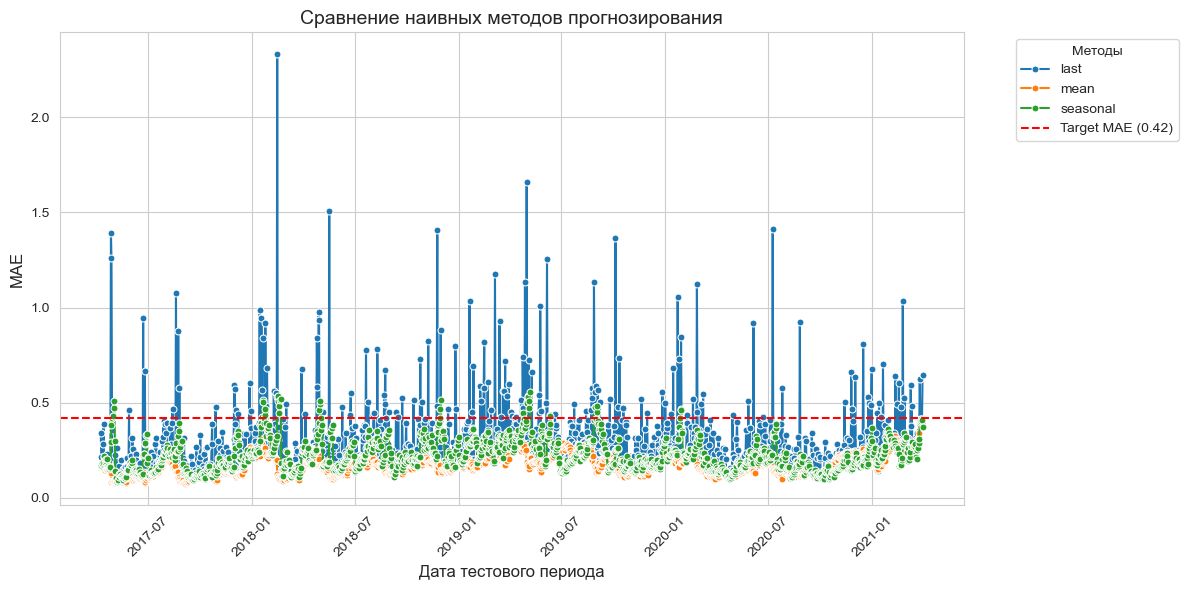

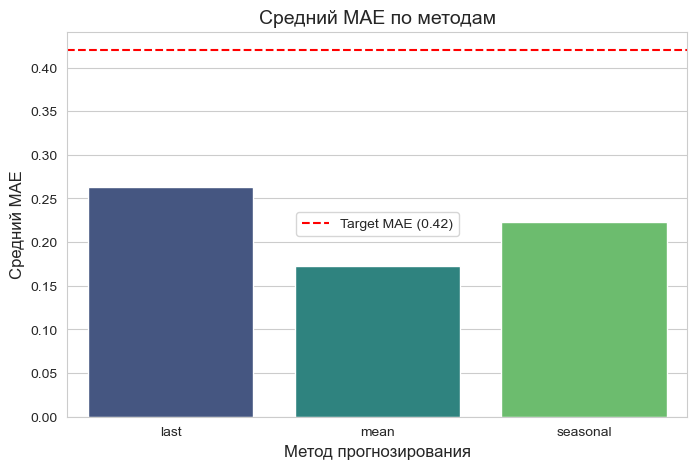

In [304]:
combined_df = pd.concat(all_results)

# Создаем график
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Линии MAE для каждого метода
sns.lineplot(data=combined_df, 
             x='Date', 
             y='MAE', 
             hue='Strategy',
             marker='o',
             markersize=5,
             linewidth=1.5)

# Горизонтальная линия целевого значения
plt.axhline(y=0.42, color='red', linestyle='--', label='Target MAE (0.42)')

# Настройки отображения
plt.title('Сравнение наивных методов прогнозирования', fontsize=14)
plt.xlabel('Дата тестового периода', fontsize=12)
plt.ylabel('MAE', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Методы', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Дополнительно: столбчатая диаграмма средних значений
mean_mae = combined_df.groupby('Strategy')['MAE'].mean().reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(data=mean_mae, x='Strategy', y='MAE', palette='viridis')
plt.axhline(y=0.42, color='red', linestyle='--', label='Target MAE (0.42)')
plt.title('Средний MAE по методам', fontsize=14)
plt.xlabel('Метод прогнозирования', fontsize=12)
plt.ylabel('Средний MAE', fontsize=12)
plt.legend()
plt.show()

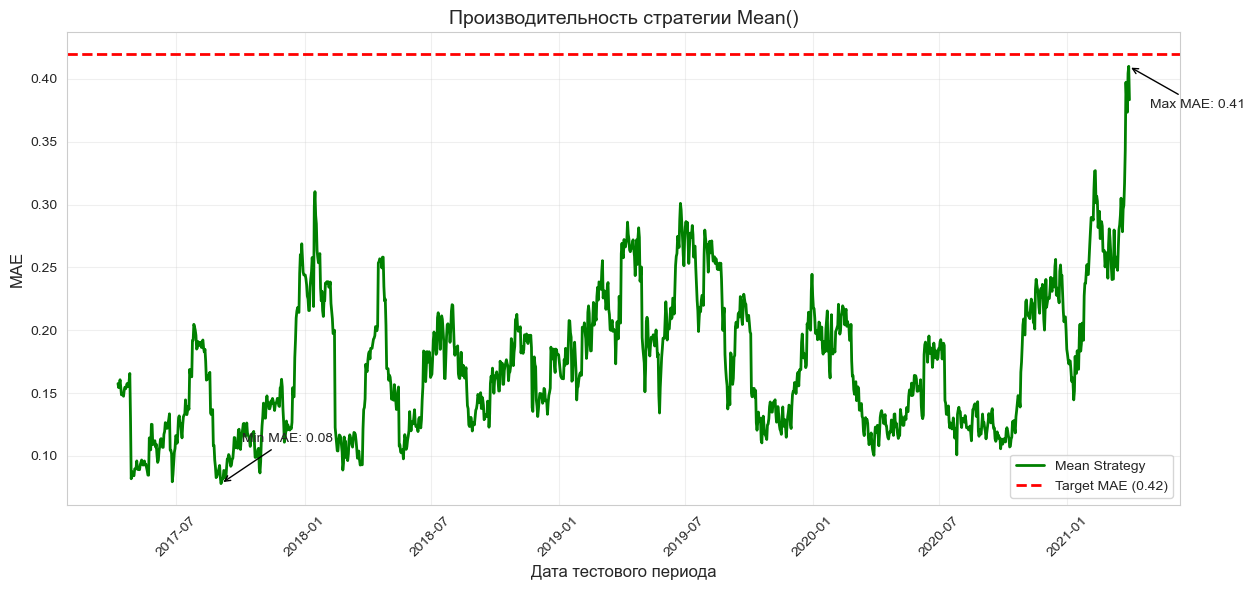

In [308]:
# График для стратегии mean() с целевым значением
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Фильтрация данных только для mean()
mean_df = combined_df[combined_df['Strategy'] == 'mean']

# Построение графика
sns.lineplot(data=mean_df,
             x='Date',
             y='MAE',
             color='green',
             markersize=7,
             linewidth=2,
             label='Mean Strategy')

# Целевое значение и оформление
plt.axhline(y=0.42, color='red', linestyle='--', linewidth=2, label='Target MAE (0.42)')
plt.fill_between(mean_df['Date'], 
                 mean_df['MAE'], 
                 0.42,
                 where=(mean_df['MAE'] > 0.42),
                 color='red', 
                 alpha=0.1,
                 interpolate=True)

# Настройки отображения
plt.title('Производительность стратегии Mean()', fontsize=14)
plt.xlabel('Дата тестового периода', fontsize=12)
plt.ylabel('MAE', fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Аннотация для максимального и минимального значений
max_mae = mean_df['MAE'].max()
min_mae = mean_df['MAE'].min()
plt.annotate(f'Max MAE: {max_mae:.2f}',
             xy=(mean_df['Date'][mean_df['MAE'].idxmax()], max_mae),
             xytext=(15, -30),
             textcoords='offset points',
             arrowprops=dict(arrowstyle='->', color='black'))

plt.annotate(f'Min MAE: {min_mae:.2f}',
             xy=(mean_df['Date'][mean_df['MAE'].idxmin()], min_mae),
             xytext=(15, 30),
             textcoords='offset points',
             arrowprops=dict(arrowstyle='->', color='black'))

plt.show()

### 2. ДЛЯ ПРОЕКТА (Добавил этап отбора признаков перед ретрейном)

In [254]:
class ARIMAPipeline:
    """
    - генерация и отбор признаков по входящим данным
    - итеративное разделение на train/valid/test
    - имитация увеличивающейся обучающей выборки или скользящего окна
    - заполнение пропусков
    - автоматический ре-трейн по расписанию и при дрейфе
    - логирование MAE и флага ре-трейна
    """
    def __init__(self,
                 dataframe: pd.DataFrame,
                 date_col: str = 'date',
                 target_col: str = 'saldo',
                 train_sample_format: str = 'sliding_window',  # 'increasing' или 'sliding_window'
                 inplace_type: str = '-1e10',              # или 'mean'
                 test_days: int = 30,
                 min_train_days: int = 60,
                 retrain_freq: int = 30,
                 drift_threshold: float = 0.05,
                 # Параметры генерации признаков
                 lag_target: int = 7,
                 lag_macro: int = 3,
                 roll_windows: list[int] = [7, 30],
                 # Параметры отбора признаков
                 k_filter: int = 30,
                 boruta_n_estimators: int = 100,
                 embedded_method: str = 'lasso',
                 cv: int = 5,
                 feature_selection_random_state: int = 42):
        
        self.df = dataframe.copy()
        self.date_col = date_col
        self.target_col = target_col
        self.train_sample_format = train_sample_format
        self.inplace_type = inplace_type
        self.test_days = test_days
        self.min_train_days = min_train_days
        self.retrain_freq = retrain_freq
        self.drift_threshold = drift_threshold
        self.lag_target = lag_target
        self.lag_macro = lag_macro
        self.roll_windows = roll_windows
        self.k_filter = k_filter
        self.boruta_n_estimators = boruta_n_estimators
        self.embedded_method = embedded_method
        self.cv = cv
        self.feature_selection_random_state = feature_selection_random_state
        self.feature_selection_history = []  # Инициализация истории


        # Подготовка датафрейма
        self.df[self.date_col] = pd.to_datetime(self.df[self.date_col])
        self.df.sort_values(self.date_col, inplace=True)
        self.df.set_index(self.date_col, inplace=True)
        self.df = self.df.asfreq('D').fillna(method='ffill')
        
        # Генерация признаков
        self.df = generate_features(
            self.df,
            target_col=self.target_col,
            lag_target=self.lag_target,
            lag_macro=self.lag_macro,
            roll_windows=self.roll_windows
        )
        
        self.scaler = StandardScaler()
        self.selected_features = None
        self.model = None
        self.last_retrain_idx = None
        self.df_results = pd.DataFrame(columns=[
            'Date', 'train_period', 'test_period', 'MAE', 'Retrained'
        ])

    def run_loop(self) -> pd.DataFrame:
        prev_mae = None
          
        for idx in tqdm(range(self.min_train_days,
                               len(self.df) - self.test_days + 1)):
            
            # Формирование train и test
            if self.train_sample_format == 'increasing':
                df_train = self.df.iloc[:idx]
            else:
                df_train = self.df.iloc[idx - self.min_train_days:idx]
            df_test = self.df.iloc[idx: idx + self.test_days]

            # Разделение на train/valid
            train_split, valid_split = train_test_split(
                df_train, test_size=0.2, shuffle=False)
            x_train = train_split.drop(columns=[self.target_col])
            y_train = train_split[self.target_col]
            x_valid = valid_split.drop(columns=[self.target_col])
            y_valid = valid_split[self.target_col]
            x_test  = df_test.drop(columns=[self.target_col])
            y_test  = df_test[self.target_col]

            # Заполнение пропусков
            if self.inplace_type == '-1e10':
                fill_val = -1e10
                x_train.fillna(fill_val, inplace=True)
                x_valid.fillna(fill_val, inplace=True)
                x_test.fillna(fill_val, inplace=True)
            else:
                mean_vals = x_train.mean()
                x_train.fillna(mean_vals, inplace=True)
                x_valid.fillna(mean_vals, inplace=True)
                x_test.fillna(mean_vals, inplace=True)

            train_period = f"{y_train.index.min().date()}/{y_train.index.max().date()}"
            test_period  = f"{y_test.index.min().date()}/{y_test.index.max().date()}"

            # Проверка необходимости ретрейна
            retrained = False
            if (self.model is None or
                (self.last_retrain_idx is not None and idx - self.last_retrain_idx >= self.retrain_freq)):
                retrained = True
                self._train_model(pd.concat([x_train, x_valid]),
                                   pd.concat([y_train, y_valid]))
                self.last_retrain_idx = idx

            # Прогноз
            if self.selected_features is not None:
                x_test_feat = x_test[self.selected_features]
                X_test_scaled = self.scaler.transform(x_test_feat)
                y_pred = self.model.predict(n_periods=len(X_test_scaled), X=X_test_scaled)
                mae = mean_absolute_error(y_test, y_pred)
            else:
                mae = np.nan

            # Проверка дрейфа
            if prev_mae is not None and mae - prev_mae > self.drift_threshold:
                retrained = True
                self._train_model(pd.concat([x_train, x_valid]),
                                   pd.concat([y_train, y_valid]))
                if self.selected_features is not None:
                    X_test_scaled = self.scaler.transform(x_test[self.selected_features])
                    y_pred = self.model.predict(n_periods=len(X_test_scaled), X=X_test_scaled)
                    mae = mean_absolute_error(y_test, y_pred)
                self.last_retrain_idx = idx

            # Логирование
            self.df_results.loc[len(self.df_results)] = [
                y_test.index[-1].date(),
                train_period,
                test_period,
                mae,
                retrained
            ]
            prev_mae = mae

        return self.df_results

    def _train_model(self, X: pd.DataFrame, y: pd.Series):
        # Объединение данных для отбора признаков
        df_train = X.join(y)
        feature_cols = X.columns.tolist()
        
        # Отбор признаков
        selection_result = sequential_feature_selection(
            df=df_train,
            feature_cols=feature_cols,
            target_col=self.target_col,
            k_filter=self.k_filter,
            boruta_n_estimators=self.boruta_n_estimators,
            embedded_method=self.embedded_method,
            cv=self.cv,
            random_state=self.feature_selection_random_state
        )
        self.selected_features = selection_result['final']
        
        if not self.selected_features:
            raise ValueError("No features selected. Check feature selection parameters.")
        
        # Масштабирование и обучение
        X_selected = X[self.selected_features]
        X_scaled = self.scaler.fit_transform(X_selected)
        
        self.model = auto_arima(
            y=y,
            exogenous=X_scaled,
            seasonal=True,
            m=7,
            error_action='ignore',
            suppress_warnings=True,
            stepwise=True
        )

        # Сохраняем выбранные признаки в историю
        self.feature_selection_history.append({
            'retrain_date': X.index.max(),  # Дата последнего наблюдения в обучающих данных
            'features': self.selected_features.copy()
        })

    def get_feature_frequency(self, top_n: int = None) -> pd.DataFrame:
            """
            Возвращает частоту появления признаков в истории отбора.
            
            Параметры:
                top_n: Если указано, возвращает топ-N признаков
            
            Возвращает:
                pd.DataFrame: Признаки и их частоты, отсортированные по убыванию
            """
            freq = defaultdict(int)
            for entry in self.feature_selection_history:
                for feature in entry['features']:
                    freq[feature] += 1
                    
            df = (
                pd.DataFrame.from_dict(freq, orient='index', columns=['count'])
                .sort_values('count', ascending=False)
                .reset_index()
                .rename(columns={'index': 'feature'})
            )
            
            return df.head(top_n) if top_n else df

    def get_feature_history(self) -> pd.DataFrame:
        """
        Возвращает полную историю отбора признаков.
        
        Возвращает:
            pd.DataFrame: Дата ретрейна и список признаков
        """
        return pd.DataFrame(self.feature_selection_history)

In [241]:
arima_pipeline = ARIMAPipeline(df)

In [243]:
arima_pipeline.run_loop()

100%|██████████| 56/56 [00:00<00:00, 1555503.47it/s]

100%|██████████| 55/55 [00:00<00:00, 1190.52it/s]

100%|██████████| 54/54 [00:00<00:00, 837.59it/s]

100%|██████████| 53/53 [00:00<00:00, 564.09it/s]

100%|██████████| 52/52 [00:00<00:00, 429.05it/s]

100%|██████████| 51/51 [00:00<00:00, 346.94it/s]

100%|██████████| 50/50 [00:00<00:00, 290.84it/s]

100%|██████████| 49/49 [00:00<00:00, 241.28it/s]

100%|██████████| 48/48 [00:00<00:00, 213.69it/s]

100%|██████████| 47/47 [00:00<00:00, 192.45it/s]

100%|██████████| 46/46 [00:00<00:00, 171.98it/s]

100%|██████████| 45/45 [00:00<00:00, 153.82it/s]

100%|██████████| 44/44 [00:00<00:00, 141.59it/s]

100%|██████████| 43/43 [00:00<00:00, 133.33it/s]

100%|██████████| 42/42 [00:00<00:00, 121.05it/s]

100%|██████████| 41/41 [00:00<00:00, 115.98it/s]

100%|██████████| 40/40 [00:00<00:00, 109.26it/s]

100%|██████████| 39/39 [00:00<00:00, 88.54it/s] 

100%|██████████| 38/38 [00:00<00:00, 94.89it/s]

100%|██████████| 37/37 [00:00<00:00, 89.31it/s

,Date,train_period,test_period,MAE,Retrained
0,2017-04-15,2017-01-16/2017-03-04,2017-03-17/2017-04-15,0.142056,True
1,2017-04-16,2017-01-17/2017-03-05,2017-03-18/2017-04-16,0.149461,False
2,2017-04-17,2017-01-18/2017-03-06,2017-03-19/2017-04-17,0.151248,False
3,2017-04-18,2017-01-19/2017-03-07,2017-03-20/2017-04-18,0.159308,False
4,2017-04-19,2017-01-20/2017-03-08,2017-03-21/2017-04-19,0.155713,False
...,...,...,...,...,...
1442,2021-03-27,2020-12-28/2021-02-13,2021-02-26/2021-03-27,0.361399,False
1443,2021-03-28,2020-12-29/2021-02-14,2021-02-27/2021-03-28,0.386023,False
1444,2021-03-29,2020-12-30/2021-02-15,2021-02-28/2021-03-29,0.400600,False
1445,2021-03-30,2020-12-31/2021-02-16,2021-03-01/2021-03-30,0.394143,False


In [246]:
df_res = arima_pipeline.df_results

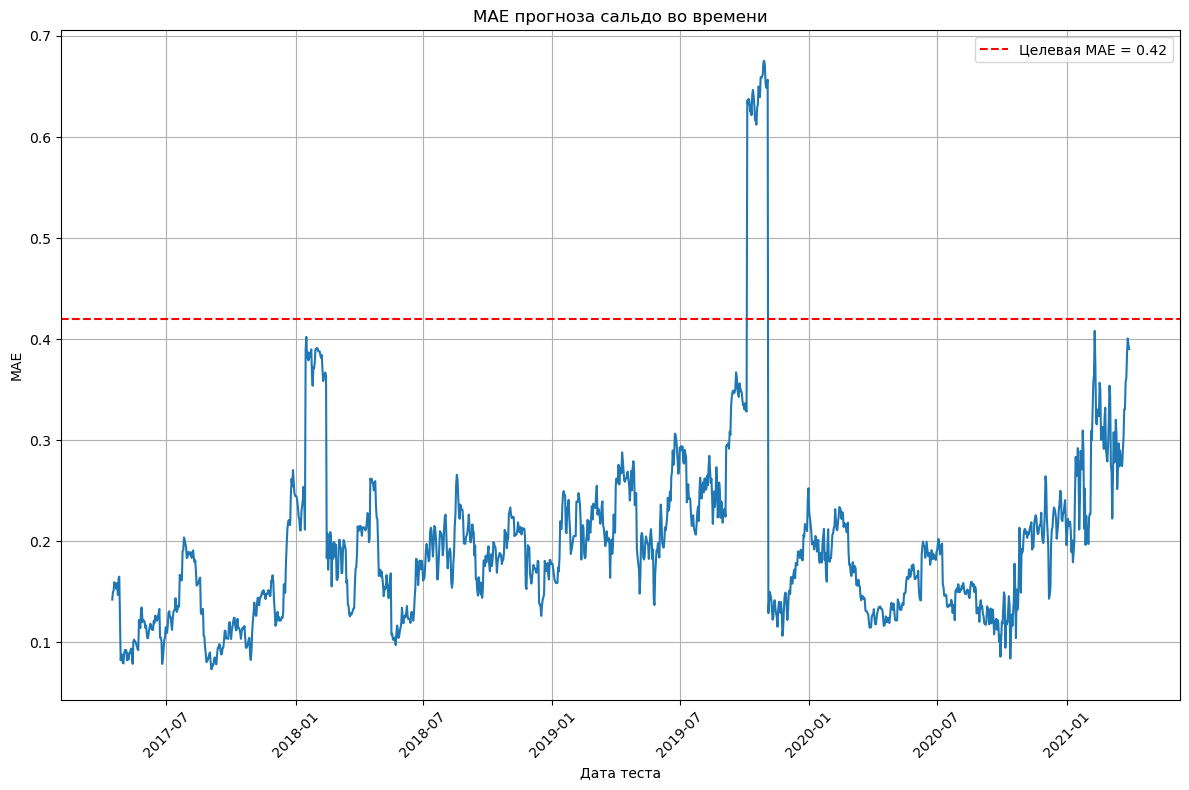

In [248]:
# Если Date хранится не в datetime
df_res['Date'] = pd.to_datetime(df_res['Date'])

# Построение
plt.figure(figsize=(12, 8))
plt.plot(df_res['Date'], df_res['MAE'], linestyle='-')
plt.axhline(y=0.42, color='red', linestyle='--', label='Целевая MAE = 0.42')
plt.title('MAE прогноза сальдо во времени')
plt.xlabel('Дата теста')
plt.ylabel('MAE')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [260]:
arima_pipeline.get_feature_frequency(15)

,feature,count
0,saldo_diff1,67
1,outcome,65
2,income,65
3,saldo_lag1,34
4,dow,3
5,usd_vol_today,2
6,eur_vol_today,2
7,gdp_abs,2
8,saldo_lag7,2
9,tax_payments,2


In [262]:
arima_pipeline.get_feature_history()

,retrain_date,features
0,2017-03-16,"[outcome, saldo_diff1, income]"
1,2017-04-15,"[outcome, saldo_diff1, income, saldo_lag1]"
2,2017-05-15,"[outcome, saldo_diff1, income, saldo_lag1]"
3,2017-06-14,"[outcome, saldo_diff1, income, saldo_lag1]"
4,2017-07-14,"[income, saldo_diff1, outcome]"
...,...,...
62,2021-01-02,"[income, saldo_diff1, outcome, saldo_lag1]"
63,2021-01-04,"[outcome, saldo_diff1, income, saldo_lag1]"
64,2021-01-06,"[outcome, saldo_diff1, income, saldo_lag1]"
65,2021-02-05,"[income, saldo_diff1, outcome, saldo_lag1]"
